In [3]:
import os

os.environ["SEED"] = "0"
import numpy as np
import pandas as pd
from ConfigSpace import Configuration

from src.aac.AAC import AAC
from src.configuration_space.LKH import CONFIGURATION_SPACE
from src.constant import DATA_DIR, SEED, DATABASE_DIR, MAIN_DIR
from src.database import DB
from src.database.queries import *
from src.instance.Instance import Instance
from src.instance.InstanceList import InstanceList
from src.instance.TSP_Instance import TSP_Instance, TSP_train_test_from_index_file, TSP_from_index_file
from src.solver.Portfolio import Portfolio
from src.solver.TSP_LKH_Solver import TSP_LKH_Solver
from src.aac.SurrogateEstimator import Estimator1, SurrogateEstimator

In [4]:
# cluster_netgen
# compression
# expansion
# explosion
# grid
# cluster
# implosion
# linearprojection
# rotation
# uniform_portgen

In [5]:
N = 30

test_instances = TSP_from_index_file(
    filepath=DATA_DIR / "TSP" / "TEST" / "index.json"
)
instances = TSP_from_index_file(filepath=DATA_DIR / "TSP" / "TRAIN" / "index.json")
number_of_instances = N // 5
train_instances = InstanceList()
for i in range(5):
    train_instances.extend(instances[i * 200 : i * 200 + number_of_instances])

In [4]:
portfolio = Portfolio.from_solver_class(TSP_LKH_Solver, size=2)
portfolio

Portfolio(size=2)[Solver(id=52980316141715150), Solver(id=473831520656465062)]

In [39]:
instance = train_instances[0]
portfolio[0].solve(instance, prefix="tmp", cache=False)

[2025-01-22 10:17:50] DEBUG     solve(prefix=tmp, solver=Solver(id=52980316141715150), instance=TSP_Instance(filepath=TSP/TRAIN/cluster_netgen/000.tsp))
[2025-01-22 10:18:03] DEBUG     Solver.Result(prefix=tmp, solver=Solver(id=52980316141715150), instance=TSP_Instance(filepath=TSP/TRAIN/cluster_netgen/000.tsp), cost=100.00, time=10.00, cached=False, surrogate=False, error=False)


<Future at 0x1a3b2c99f30 state=finished returned Result>

In [41]:
instance = test_instances[41]
instance

TSP_Instance(filepath=TSP/TEST/rotation/001.tsp)

In [25]:
db = DB(DATABASE_DIR / "run-plain-30-951423.db")

In [26]:
instances = pd.read_sql_query("SELECT * FROM instances", db._conn)
instances.loc[instances.filepath == "TSP/TEST/rotation/001.tsp"]

,id,filepath,optimum,angle_min,angle_median,angle_mean,angle_max,angle_sd,angle_span,angle_coef_of_var,...,mst_dists_span,mst_dists_coef_of_var,mst_dists_sum,nnds_min,nnds_median,nnds_mean,nnds_max,nnds_sd,nnds_span,nnds_coef_of_var
71,1418111921055258004,TSP/TEST/rotation/001.tsp,15009761.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
results = pd.read_sql_query("SELECT * FROM results", db._conn)
results.loc[(results["instance_id"] == "1418111921055258004")]

,id,prefix,solver_id,instance_id,cost,time,cached,surrogate,error
4574,test0_897762958910684284_1418111921055258004,test0,897762958910684284,1418111921055258004,0.34,0.34,0,0,0
4575,test0_1850711876884253793_1418111921055258004,test0,1850711876884253793,1418111921055258004,1.52,1.52,0,0,0
4675,test1_897762958910684284_1418111921055258004,test1,897762958910684284,1418111921055258004,0.27,0.27,0,0,0
4699,test1_1850711876884253793_1418111921055258004,test1,1850711876884253793,1418111921055258004,100.00,10.00,0,0,0
4783,test2_897762958910684284_1418111921055258004,test2,897762958910684284,1418111921055258004,2.96,2.96,0,0,0
...,...,...,...,...,...,...,...,...,...
14294,test97_897762958910684284_1418111921055258004,test97,897762958910684284,1418111921055258004,5.94,5.94,0,0,0
14396,test98_897762958910684284_1418111921055258004,test98,897762958910684284,1418111921055258004,7.90,7.90,0,0,0
14398,test98_1850711876884253793_1418111921055258004,test98,1850711876884253793,1418111921055258004,100.00,10.00,0,0,0
14495,test99_897762958910684284_1418111921055258004,test99,897762958910684284,1418111921055258004,7.07,7.07,0,0,0


In [44]:

(results.loc[(results["instance_id"] == "1418111921055258004") & (results["solver_id"] == "897762958910684284"), "cost"] == 100).value_counts()

False    73
True     27
Name: cost, dtype: int64

In [45]:
solver = TSP_LKH_Solver.from_db("897762958910684284", db=db)

In [46]:
solver.solve(instance, prefix="tmp", cache=False)

[2025-01-22 11:19:49] DEBUG     solve(prefix=tmp, solver=Solver(id=897762958910684284), instance=TSP_Instance(filepath=TSP/TEST/rotation/001.tsp))
[2025-01-22 11:19:59] DEBUG     Solver.Result(prefix=tmp, solver=Solver(id=897762958910684284), instance=TSP_Instance(filepath=TSP/TEST/rotation/001.tsp), cost=100.00, time=10.00, cached=False, surrogate=False, error=False)


<Future at 0x1baae0dc970 state=finished returned Result>

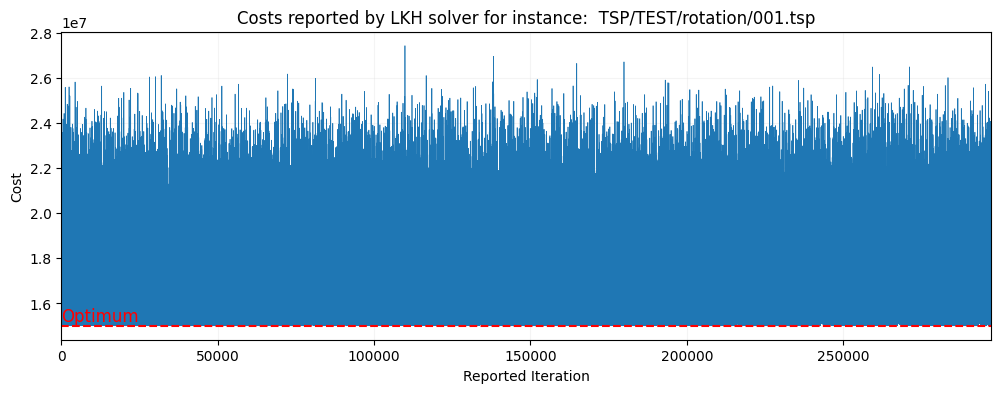

In [49]:
costs = []

with open("tmp.log", "r") as f:
    for line in f:
        if not line.startswith("Cost = "):
            continue
        v = line.split(", ")[0]
        v = v.split(" = ")[1]
        v = float(v)
        costs.append(v)

import matplotlib.pyplot as plt

plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

plt.plot(costs, lw=0.5)
plt.axhline(y=instance.optimum, color="red", linestyle="--")
plt.xlabel("Reported Iteration")
plt.ylabel("Cost")
plt.title(f"Costs reported by LKH solver for instance:  {instance._get_short_filepath()}")
plt.text(1, instance.optimum, "Optimum", color="red", fontsize=12, verticalalignment="bottom")
plt.show()

In [16]:
test_instances[0].optimum

7643994.0

In [ ]:
aac = AAC(
    portfolio=portfolio,
    instance_list=train_instances,
    prefix="config",
    max_iter=75,
    calculate_features=True,
    estimator=None,
)

last_model_iter = 0

estimator = None
db = DB()
estimator_pct = 0.5
for _ in aac.configure_iter():
    if aac.iter > 25 and aac.iter - last_model_iter >= 5:
        X, y = get_model_training_data(db)
        estimator = Estimator1(
            max_cost=TSP_LKH_Solver.MAX_COST, estimator_pct=estimator_pct
        )
        estimator.fit(X, y)
        estimator.log()
        last_model_iter = aac.iter
        aac.update(estimator=estimator)

[2025-01-10 22:05:45] DEBUG     AAC(prefix=config, iter=1, configuration_time=[inf inf])
[2025-01-10 22:05:45] DEBUG     Portfolio.evaluate(config;aac_iter=1)
[2025-01-10 22:05:45] DEBUG     Portfolio(size=2)[Solver(id=52980316141715150), Solver(id=473831520656465062)]
[2025-01-10 22:05:45] DEBUG     solve(prefix=config;aac_iter=1, solver=Solver(id=52980316141715150), instance=TSP_Instance(filepath=TSP/CEPS_benchmark/cluster_netgen/01.tsp))
[2025-01-10 22:05:45] DEBUG     calculate_features(instance=TSP_Instance(filepath=TSP/CEPS_benchmark/cluster_netgen/01.tsp))


In [10]:
# db = DB()
# db = DB("database/run-245-sur-50-943490.db")
db = DB("run-plain-500-946678.db")

In [11]:
instances = pd.read_sql_query("SELECT * FROM instances", db._conn)
instances

,id,filepath,optimum,angle_min,angle_median,angle_mean,angle_max,angle_sd,angle_span,angle_coef_of_var,...,mst_dists_span,mst_dists_coef_of_var,mst_dists_sum,nnds_min,nnds_median,nnds_mean,nnds_max,nnds_sd,nnds_span,nnds_coef_of_var
0,822075595471039179,TSP/CEPS_benchmark/cluster_netgen/01.tsp,9080004.0,0.011018,1.411569,1.481377,3.129632,0.897300,3.118615,0.605720,...,0.511327,1.988531,0.000023,0.000083,0.005401,0.007307,0.075516,0.006976,0.075433,0.954695
1,411598327185181776,TSP/CEPS_benchmark/cluster_netgen/02.tsp,11020488.0,0.006047,1.536236,1.561506,3.138415,0.923695,3.132368,0.591541,...,0.209516,1.114900,0.000033,0.000135,0.006975,0.009557,0.082717,0.009342,0.082583,0.977547
2,56462699908304675,TSP/CEPS_benchmark/cluster_netgen/03.tsp,9746976.0,0.005927,1.392946,1.468175,3.140087,0.912639,3.134160,0.621614,...,0.306416,1.304984,0.000026,0.000108,0.006658,0.008358,0.072008,0.007407,0.071900,0.886158
3,1135796868948507057,TSP/CEPS_benchmark/cluster_netgen/04.tsp,8918339.0,0.003895,1.407044,1.487371,3.135897,0.929052,3.132002,0.624627,...,0.329118,1.366889,0.000025,0.000456,0.005884,0.007701,0.056836,0.007017,0.056380,0.911088
4,900769072242699328,TSP/CEPS_benchmark/cluster_netgen/05.tsp,10525131.0,0.004843,1.532593,1.541054,3.139785,0.893347,3.134942,0.579699,...,0.243854,1.272756,0.000029,0.000339,0.006925,0.008669,0.100568,0.007912,0.100229,0.912758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,1765803814609198146,TSP/CEPS_benchmark/grid/00.tsp,21258773.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506,730618644385552802,TSP/CEPS_benchmark/implosion/00.tsp,20437744.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
507,396111139638522607,TSP/CEPS_benchmark/linearprojection/00.tsp,13972705.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
508,310544774750200091,TSP/CEPS_benchmark/rotation/00.tsp,16119107.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
results = pd.read_sql_query("SELECT * FROM results", db._conn)
results

,id,prefix,solver_id,instance_id,cost,time,cached,surrogate,error
0,config;aac_iter=1_52980316141715150_8220755954...,config;aac_iter=1,52980316141715150,822075595471039179,200.00,40.673398,0,0,1
1,config;aac_iter=1_473831520656465062_822075595...,config;aac_iter=1,473831520656465062,822075595471039179,200.00,20.000000,0,0,1
2,config;aac_iter=1_52980316141715150_4115983271...,config;aac_iter=1,52980316141715150,411598327185181776,200.00,27.245082,0,0,0
3,config;aac_iter=1_473831520656465062_411598327...,config;aac_iter=1,473831520656465062,411598327185181776,200.00,20.000000,0,0,1
4,config;aac_iter=1_52980316141715150_5646269990...,config;aac_iter=1,52980316141715150,56462699908304675,200.00,26.370338,0,0,1
...,...,...,...,...,...,...,...,...,...
76995,test99_699052001317236703_1239352391178630764,test99,699052001317236703,1239352391178630764,8.27,8.270000,0,0,0
76996,test99_699052001317236703_1018017649469757748,test99,699052001317236703,1018017649469757748,15.66,15.660000,0,0,0
76997,test99_699052001317236703_648058674037521772,test99,699052001317236703,648058674037521772,200.00,20.000000,0,0,0
76998,test99_699052001317236703_2137644624762416652,test99,699052001317236703,2137644624762416652,200.00,20.000000,0,0,0


In [26]:
idx = instances.loc[instances["filepath"].str.contains("/MY/"), "id"].unique()
(results.loc[results["instance_id"].isin(idx), "cost"]).describe()

count    38250.000000
mean       145.778045
std         86.842446
min          0.020000
25%         14.762500
50%        200.000000
75%        200.000000
max        200.000000
Name: cost, dtype: float64

In [27]:
results.loc[results["prefix"].str.startswith("config"), "surrogate"].mean()

0.2523537414965986